In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import matplotlib
import skimage

from collections import deque
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from dataclasses import dataclass

c:\Users\thegr\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
DATASET_NUMBER = 2

cap = cv.VideoCapture(f"..\\datasets\\unzipped\\endovis\\Tracking_Robotic_Training\\Training\\Dataset{DATASET_NUMBER}\\Video.avi")
tracking_data = open(r"..\datasets\unzipped\endovis\Tracking_Robotic_Training\Training\Dataset2\Pose.txt", "r")

# Feature parameters
feature_params = {
    "maxCorners": 100,
    "qualityLevel": 0.3,
    "minDistance": 7,
    "blockSize": 7 
}

# Lucas Kinade parameters
lk_params = {
    "winSize": (25, 25),
    "maxLevel": 4,
    "criteria": (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)
}

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

# Initialize flag to end viewing when q is pressed
stop = False

frame_number = 0

vectors = []
true_vectors = []
tip_position = []

initial_vals = [float(x) for x in tracking_data.readline().split(" ")[:2]]

points = [deque(maxlen = 50) for _ in range(p0.shape[0])]

# video_writer = cv.VideoWriter(f'optical_flow_dataset_{DATASET_NUMBER}.avi',  
#                         cv.VideoWriter_fourcc('M', 'J', 'P', 'G'), 
#                         25, (old_gray.shape[1], old_gray.shape[0])) 

# video_writer.write(old_frame)

while (not stop):
    ret,frame = cap.read()
    if frame is None:
        print("End of video, breaking")
        break
    
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    if p1 is None: 
        print("Failed to extract features")
        continue

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    new_vals = [float(x) for x in tracking_data.readline().split(" ")[:2]]

    vectors.append(np.array(good_new) - np.array(good_old))
    true_vectors.append(np.array(new_vals) - np.array(initial_vals))
    tip_position.append(np.array(new_vals))
    initial_vals = new_vals

    try:
        norm = np.linalg.norm(vectors[-1], axis = 1)

        idxs = np.where(norm > np.mean(norm))[0]
        estimated_angle = \
            (np.median([np.arctan2(vectors[-1][:,1], vectors[-1][:,0])[i] for i in idxs]))
            # (np.average([np.arctan2(vectors[-1][:,1], vectors[-1][:,0])[i] for i in idxs]))
        
        # correct_angles.append(
        #     normalize_angle(np.arctan2(vec_true[1], vec_true[0]))
        # )

        estimated_magnitude = \
            np.median([norm[i] for i in idxs])
            # np.average([norm[i] for i in idxs])
        
        RED = (0, 0, 255)
        BLUE = (255, 0, 0)
        GREEN = (0, 255, 0)

        mask = np.zeros_like(old_frame)
        frame_copy = frame.copy()

        # Draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            
            # Set values to integers to allow for drawing
            points[i].append((int(a), int(b), int(c), int(d)))

            for a, b, c, d in points[i]:
                # mask = cv.line(mask, (a,b),(c,d), GREEN if i in idxs else RED, 1)
                # frame_copy = cv.circle(frame_copy, (a,b), 3, GREEN if i in idxs else RED, -1)
                mask = cv.line(mask, (a,b),(c,d), (127, 127, 127), 1)
                frame_copy = cv.circle(frame_copy, (a,b), 3, (255, 255, 0), -1)
        
        # correct_magnitude.append(
        #     (np.linalg.norm(vec_true))
        # )

        img = cv.add(frame_copy, mask)
        # print((tip_position[-1][0], tip_position[-1][1]), 
        #     (tip_position + estimated_magnitude*np.cos(estimated_angle),
        #      tip_position + estimated_magnitude*np.sin(estimated_angle)))
        # cv.arrowedLine(
        #     img, 
        #     (int(tip_position[-1][0]), int(tip_position[-1][1])), 
        #     (int(tip_position[-1][0] + min(estimated_magnitude*25, 100)*np.cos(estimated_angle)), int(tip_position[-1][1] + min(estimated_magnitude*25, 100)*np.sin(estimated_angle))),
        #     color = BLUE,
        #     thickness = 10,
        #     tipLength = 0.25
        # )
        # video_writer.write(img)
        
        frame_number += 1
        
        # cv.imshow("Frame", frame.copy())
        # cv.waitKey(0)
        # cv.destroyAllWindows()
        # if frame_number == 500:
        #     cv.imshow("Frame", img)
        #     cv.waitKey(0)
        #     cv.destroyAllWindows()
        #     break
        
        # while True:
        #     # Exit if 'q' is pressed
        #     if cv.waitKey(25) & 0xFF == ord('q'):
        #         stop = True
        #         break
        #     elif cv.waitKey(33) == 32: break
                                                                    
        # # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    except Exception as e:
        print(f"Iteration failed: {e}")

cap.release()
# video_writer.release()
cv.destroyAllWindows()

End of video, breaking


In [3]:
def normalize_angle(angle: float):
    # if angle < 0.0: return angle + 2*np.pi
    return angle

estimated_angles = []
correct_angles = []
estimated_magnitude = []
correct_magnitude = []

tip_vec = []

for vec, vec_true in zip(vectors, true_vectors):
    norm = np.linalg.norm(vec, axis = 1)

    idxs = np.where(norm > np.mean(norm))[0]
    estimated_angles.append(
        normalize_angle(np.average([np.arctan2(vec[:,1], vec[:,0])[i] for i in idxs]))
    )
    correct_angles.append(
        normalize_angle(np.arctan2(vec_true[1], vec_true[0]))
    )

    estimated_magnitude.append(
        np.average([norm[i] for i in idxs])
    )

    correct_magnitude.append(
        (np.linalg.norm(vec_true))
    )

%matplotlib qt
plt.figure()
plt.plot(estimated_angles)
plt.plot(correct_angles)

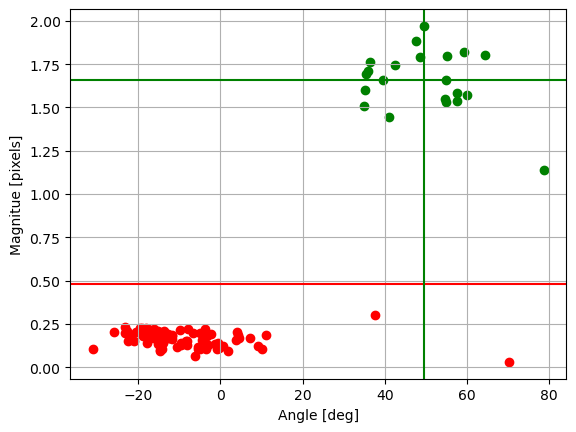

In [36]:
def normalize_angle(angle: float):
    # if angle < 0.0: return angle + 2*np.pi
    return angle

estimated_angles = []
correct_angles = []
estimated_magnitude = []
correct_magnitude = []

tip_vec = []

vec = vectors[-1]
true_vectors[-1]
norm = np.linalg.norm(vec, axis = 1)

# idxs = np.where(norm > 0.99*np.mean(norm))[0]
idxs = np.arange(len(vec))

estimated_angles = np.degrees([np.arctan2(vec[:,1], vec[:,0])[i] for i in idxs])

correct_angles.append(
    (np.arctan2(vec_true[1], vec_true[0]))
)

estimated_magnitude = [norm[i] for i in idxs]

correct_magnitude.append(
    (np.linalg.norm(vec_true))
)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(estimated_angles, estimated_magnitude)
ax.axhline(np.average(estimated_magnitude), c = "red")
ax.scatter(
    [estimated_angles[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)], 
    [estimated_magnitude[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)],
    c = "green"
)

ax.scatter(
    [estimated_angles[i] for i in idxs if estimated_magnitude[i] <= np.average(estimated_magnitude)], 
    [estimated_magnitude[i] for i in idxs if estimated_magnitude[i] <= np.average(estimated_magnitude)],
    c = "red"
)

ax.axhline(np.median([estimated_magnitude[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)]), c = "green")
ax.axvline(np.median([estimated_angles[i] for i in idxs if estimated_magnitude[i] > np.average(estimated_magnitude)]), c = "green")
ax.set_ylabel("Magnitue [pixels]")
ax.set_xlabel("Angle [deg]")
ax.grid()
# plt.plot(correct_angles)

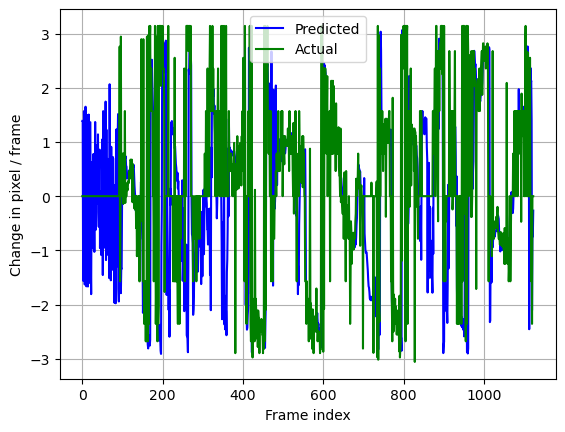

In [8]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(estimated_angles, alpha = 1.0, color = "blue", label = "Predicted")
ax.plot(correct_angles, alpha = 1.0, color = "green", label = "Actual")
ax.set_ylabel("Change in pixel / frame")
ax.set_xlabel("Frame index")
ax.set_axisbelow(True)
ax.grid()
ax.legend()

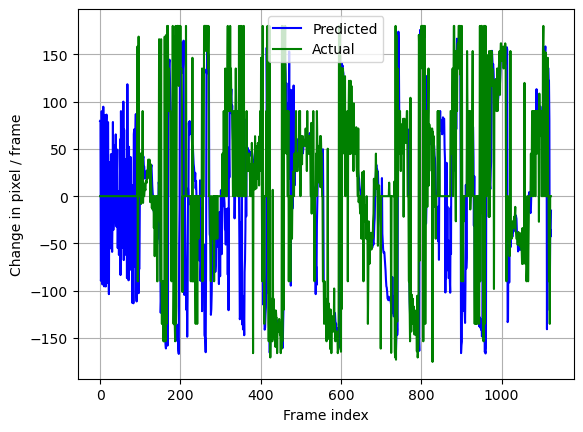

In [26]:
from scipy.signal import butter, lfilter
def lpf(data, cutoff):
    b, a = butter(2, cutoff, fs = 25)
    y = lfilter(b, a, data)
    return y

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.degrees(estimated_angles), alpha = 1, color = "blue", label = "Predicted")
ax.plot(np.degrees(correct_angles), alpha = 1, color = "green", label = "Actual")
# ax.plot(lpf(np.degrees(estimated_angles), 1.5), color = "blue", label = "Predicted")
# ax.plot(lpf(np.degrees(correct_angles), 1.5), color = "green", label = "Actual")
ax.set_ylabel("Change in pixel / frame")
ax.set_xlabel("Frame index")
ax.set_axisbelow(True)
ax.grid()
ax.legend()


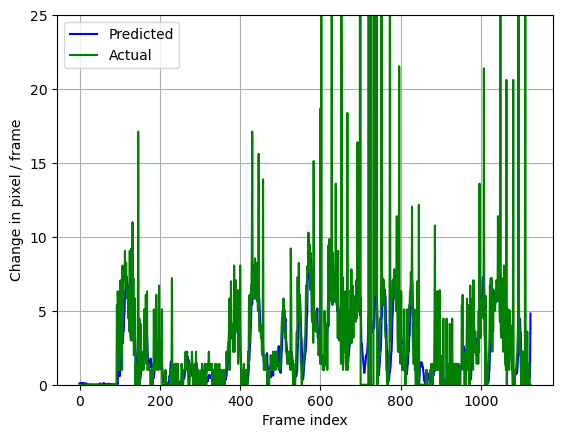

In [23]:
from scipy.signal import butter, lfilter
def lpf(data, cutoff):
    b, a = butter(2, cutoff, fs = 25)
    y = lfilter(b, a, data)
    return y

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot((estimated_magnitude), alpha = 0.1, color = "blue")
# ax.plot((correct_magnitude), alpha = 0.1, color = "green")
# ax.plot(lpf((estimated_magnitude), 1.5), color = "blue", label = "Predicted")
# ax.plot(lpf((correct_magnitude), 1.5), color = "green", label = "Actual")
ax.plot((estimated_magnitude), alpha = 1.0, color = "blue", label = "Predicted")
ax.plot((correct_magnitude), alpha = 1.0, color = "green", label = "Actual")
ax.set_ylabel("Change in pixel / frame")
ax.set_xlabel("Frame index")
ax.set_axisbelow(True)
ax.set_ylim([0, 25])
ax.grid()
ax.legend()


In [24]:
np.average(lpf(correct_magnitude, 1.5) - lpf(estimated_magnitude, 1.5)), np.std(lpf(correct_magnitude, 1.5) - lpf(estimated_magnitude, 1.5))

(3.2401308074379607, 16.368433170870926)

In [ ]:
np.average(lpf(np.degrees(correct_angles), 1.5) - lpf(np.degrees(estimated_angles), 1.5)), np.std(lpf(np.degrees(correct_angles), 1.5) - lpf(np.degrees(estimated_angles), 1.5))

In [9]:
plt.figure()
plt.plot(estimated_magnitude, alpha = 0.1, color = "blue")
plt.plot(correct_magnitude, alpha = 0.1, color = "green")
# plt.ylim([0, 100])
plt.plot(lpf(estimated_magnitude, 3), color = "blue")
plt.plot(lpf(correct_magnitude, 3), color = "green")